In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

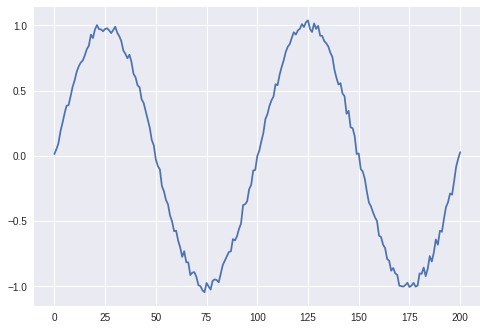

In [0]:
def sin(x, T=100):
  return np.sin(2.0*np.pi*x/T)

def toy_problem(T=100, ampl=0.05):
  x = np.arange(0, 2*T+1)
  noise = ampl * np.random.uniform(low=-1, high=1, size=len(x))
  return sin(x) + noise

f = toy_problem()
x = np.arange(0, 2*100+1)
plt.plot(x, f)

In [0]:
T = 100
length_of_sequence = 2*T
maxlen = 25

data = []
target = []
for i in range(0, length_of_sequence - maxlen + 1):
  data.append( f[i:(i+maxlen)] )
  target.append( f[i+maxlen] )

In [0]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)
X.shape, Y.shape

((176, 25, 1), (176, 1))

In [0]:
from sklearn.model_selection import train_test_split

N_train = int(len(data)*0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

## Tensorflow

In [0]:
import tensorflow as tf

In [0]:
def inference(x, n_batch, n_hidden, maxlen, n_out):
  
  def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01))
  def bias_variable(shape):
    return tf.Variable(tf.zeros(shape))
  
  cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
  initial_state = cell.zero_state(n_batch, tf.float32)
  
  ########## 수정부분 - Variable 생성
  
  Wxh = tf.get_variable('Wxh', shape=(n_in, n_hidden),
                        initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
  Whh = tf.get_variable('Whh', shape=(n_hidden, n_hidden),
                        initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
  bh = tf.get_variable('bh', shape=(1, n_hidden),
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
    
  outputs = []
  for t in range(maxlen):
    initial_state = tf.tanh(tf.matmul(x[:, t, :],Wxh) + tf.matmul(initial_state,Whh) + bh)
    outputs.append(initial_state)
  output = outputs[-1]                # 추정하고자 하는 값은 outputs의 마지막 값

  #####################################
  
  W = weight_variable([n_hidden, n_out])
  c = bias_variable([n_out])
  y = tf.matmul(output, W) + c
  return y

In [0]:
n_in = len(X[0, [0]])         # =1 (위 X.shape에서 세번째)
n_hidden = 30
n_out = len(Y[0])             # =1 (apple 주가 1개를 맞추는 게 목표, apple, amazon 등등 n개면 n_out=n)

In [0]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])
y = inference(x, n_batch, n_hidden, maxlen, n_out)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
def loss(y, t):
  mse = tf.reduce_mean(tf.square(y-t))
  return mse

In [0]:
def training(loss):
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
  train_step = optimizer.minimize(loss)
  return train_step

loss = loss(y, t)
train_step = training(loss)

In [0]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
from sklearn.utils import shuffle

In [0]:
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
    
    sess.run(train_step, feed_dict={
        x: X_[start:end], 
        t: Y_[start:end],
        n_batch: batch_size
    })
    
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation, 
        t: Y_validation, 
        n_batch: N_validation
    })
    my_loss.append(val_loss)
    print("epoch:", epoch, "validation loss:", val_loss)

epoch: 0 validation loss: 0.51070964
epoch: 1 validation loss: 0.49716413
epoch: 2 validation loss: 0.47992074
epoch: 3 validation loss: 0.46211025
epoch: 4 validation loss: 0.44327813
epoch: 5 validation loss: 0.42299542
epoch: 6 validation loss: 0.40101328
epoch: 7 validation loss: 0.38224733
epoch: 8 validation loss: 0.36450884
epoch: 9 validation loss: 0.3472812
epoch: 10 validation loss: 0.32910597
epoch: 11 validation loss: 0.3105784
epoch: 12 validation loss: 0.29256466
epoch: 13 validation loss: 0.2747011
epoch: 14 validation loss: 0.2583669
epoch: 15 validation loss: 0.2433024
epoch: 16 validation loss: 0.22978623
epoch: 17 validation loss: 0.21467747
epoch: 18 validation loss: 0.1991097
epoch: 19 validation loss: 0.18544249
epoch: 20 validation loss: 0.17359173
epoch: 21 validation loss: 0.16293691
epoch: 22 validation loss: 0.15345785
epoch: 23 validation loss: 0.14351875
epoch: 24 validation loss: 0.1335943
epoch: 25 validation loss: 0.12247345
epoch: 26 validation loss: 0.

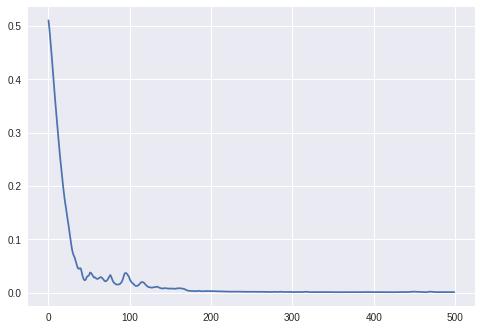

In [0]:
plt.plot(my_loss)

In [0]:
Z=X[:1]                                      # X의 첫번째 행 (초기값, 25개)
original = [f[i] for i in range(maxlen)]     # original sin data
predicted = [None for i in range(maxlen)]    # predicted values를 저장할 list

for i in range(length_of_sequence - maxlen + 1):
    z_ = Z[-1:]                              # 업데이트 되는 Z의 마지막 행 (리스트, 25개)
    y_ = y.eval(session=sess, feed_dict={ x: z_, n_batch: 1 })   # 그것으로 y를 predict
    sequence_ = np.concatenate(              # z_의 첫번째 값을 빼고 predicted 값을 붙임
       (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)    
    Z=np.append(Z, sequence_, axis=0)        # 예측한 값을 붙인 z_를 Z에 추가
    predicted.append(y_.reshape(-1))         # 예측한 y_를 predicted에 저장

In [0]:
X[-1:].shape

(1, 25, 1)

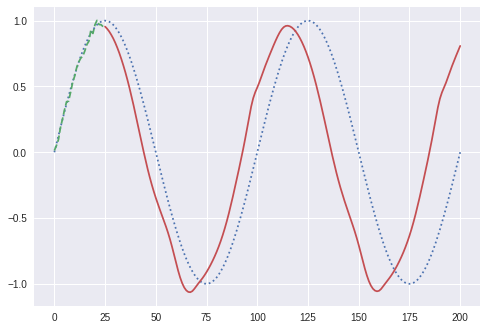

In [0]:
plt.plot(toy_problem(T=100, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)

## Keras

In [0]:
import keras
from keras.layers.recurrent import SimpleRNN
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense

In [0]:
def weight_variable(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.01))
def bias_variable(shape):
  return tf.Variable(tf.zeros(shape))

In [0]:
model = Sequential()                                     # 모델 생성
model.add(SimpleRNN(n_hidden,                            # n_hidden = 노드 수
          kernel_initializer=weight_variable,            # weight initializer의 초기값
          input_shape=(maxlen, n_out)))                  # input data의 shape 지정 (25,1)
model.add(Dense(n_out, kernel_initializer=weight_variable)) # n_out = output data 개수
model.add(Activation("linear"))                          # activation함수로 linear 사용

In [0]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999) # Adam optimizer 사용
model.compile(loss="mean_squared_error", optimizer=optimizer)         # MSE를 loss function으로 사용

In [0]:
epochs = 500
batch_size = 10
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(X_validation, Y_validation))

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 5ms/step - loss: 0.4656 - val_loss: 0.4584
Epoch 2/500
158/158 [==============================] - 0s 2ms/step - loss: 0.3550 - val_loss: 0.2916
Epoch 3/500
158/158 [==============================] - 0s 2ms/step - loss: 0.1777 - val_loss: 0.1046
Epoch 4/500
158/158 [==============================] - 0s 2ms/step - loss: 0.0979 - val_loss: 0.0478
Epoch 5/500
158/158 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0249
Epoch 6/500
158/158 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0192
Epoch 7/500
158/158 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0199
Epoch 8/500
158/158 [==============================] - 0s 3ms/step - loss: 0.0190 - val_loss: 0.0156
Epoch 9/500
158/158 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0078
Epoch 10/500
158/158 [========================

In [0]:
Z=X[:1]                                      # X의 첫번째 행 (초기값, 25개)
original = [f[i] for i in range(maxlen)]     # original sin data
predicted = [None for i in range(maxlen)]    # predicted values를 저장할 list

for i in range(length_of_sequence - maxlen + 1):
    z_ = Z[-1:]                              # 업데이트 되는 Z의 마지막 행 (리스트, 25개)
    y_ = model.predict(z_)                   # 그것으로 y를 predict
    sequence_ = np.concatenate(              # z_의 첫번째 값을 빼고 predicted 값을 붙임
       (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)    
    Z=np.append(z_, sequence_, axis=0)       # 예측한 값을 붙인 z_를 Z에 추가
    predicted.append(y_.reshape(-1))         # 예측한 y_를 predicted에 저장

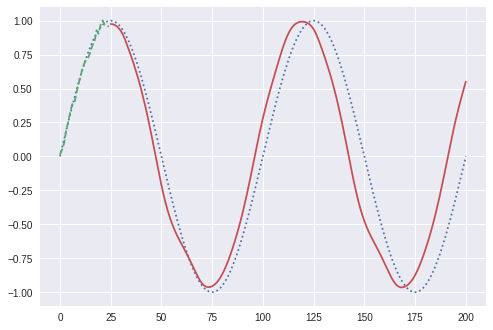

In [0]:
plt.plot(toy_problem(T, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)